In [70]:
import sklearn
import sklearn.model_selection
import numpy as np
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
import json

%matplotlib inline
import matplotlib.pyplot as plt

In [45]:
from keras.models import model_from_json

In [322]:
Xsig = np.load("/Users/joosep/Documents/jlr/data/numpy/cms_tth_1l/flat_nokin.npy")
Xsig_mem = np.load("/Users/joosep/Documents/jlr/data/numpy/cms_tth_1l/mem.npy")
evdesc_sig = np.load("/Users/joosep/Documents/jlr/data/numpy/cms_tth_1l/evdesc.npy")

idx_valid_sig = np.load("/Users/joosep/Documents/jlr/results/tth_1l_ffwd/idx_valid.npy")
idx_train_sig = np.load("/Users/joosep/Documents/jlr/results/tth_1l_ffwd/idx_train.npy")

Xbkg = np.load("/Users/joosep/Documents/jlr/data/numpy/cms_ttjets_1l/flat_nokin.npy")
evdesc_bkg = np.load("/Users/joosep/Documents/jlr/data/numpy/cms_ttjets_1l/evdesc.npy")

In [357]:
sig_sel_valid = np.zeros((len(Xsig),), dtype=np.bool)
sig_sel_valid[idx_valid_sig] = True

In [358]:
evdesc_sig.shape, evdesc_bkg.shape

((1159496, 6), (1417482, 6))

In [359]:
sel_sig = Xsig_mem[:, 2]>0.0

In [360]:
Xsig[sel_sig][0, [7,15,]]

array([0.98877 , 0.899902])

In [361]:
f = open("/Users/joosep/Documents/jlr/results/tth_1l_ffwd/model.json").read()
model = model_from_json(f)

In [362]:
model.load_weights("/Users/joosep/Documents/jlr/results/tth_1l_ffwd/model.hdf5")

In [363]:
ysig = model.predict(Xsig, batch_size=10000)
ybkg = model.predict(Xbkg, batch_size=10000)

Text(0.5,0,'JLR pred')

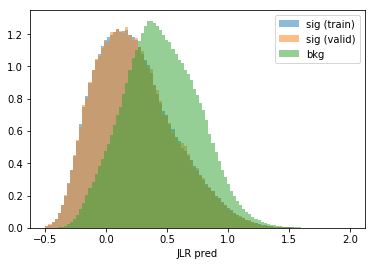

In [364]:
plt.hist(ysig[idx_train_sig], bins=np.linspace(-0.5,2,100), density=1.0, alpha=0.5, label="sig (train)");
plt.hist(ysig[idx_valid_sig], bins=np.linspace(-0.5,2,100), density=1.0, alpha=0.5, label="sig (valid)");
plt.hist(ybkg, bins=np.linspace(-0.5,2,100), density=1.0, alpha=0.5, label="bkg");
plt.legend()
plt.xlabel("JLR pred")

In [365]:
def cumhist(y, bins):
    h, _ = np.histogram(y, bins)
    ch = np.cumsum(h)/float(np.sum(h))
    return ch

def calc_roc(ysig, ybkg, bins):
    hs = cumhist(ysig, bins)
    hb = cumhist(ybkg, bins)
    
    return hs, hb

Text(0.5,0,'num_jets')

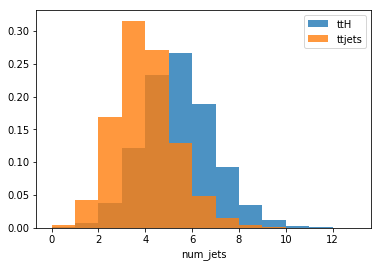

In [366]:
plt.hist(evdesc_sig[:, 1], bins=np.arange(0,14), density=1, alpha=0.8, label="ttH");
plt.hist(evdesc_bkg[:, 1], bins=np.arange(0,14), density=1, alpha=0.8, label="ttjets");
plt.legend()
plt.xlabel("num_jets")

Text(0.5,0,'nBDeepCSVM')

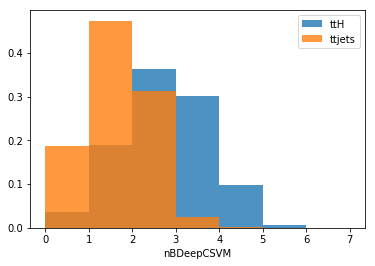

In [367]:
plt.hist(evdesc_sig[:, 2], bins=np.arange(0,8), density=1, alpha=0.8, label="ttH");
plt.hist(evdesc_bkg[:, 2], bins=np.arange(0,8), density=1, alpha=0.8, label="ttjets");
plt.legend()
plt.xlabel("nBDeepCSVM")

In [384]:
def plot_roc(njets, ntags, do_match=False, nMatch_wq=0, nMatch_tb=0, nMatch_hb=0):
    sig_sel = ((evdesc_sig[:, 0]==1) & (evdesc_sig[:, 1]==njets) & (evdesc_sig[:, 2]==ntags))
    bkg_sel = ((evdesc_bkg[:, 0]==1) & (evdesc_bkg[:, 1]==njets) & (evdesc_bkg[:, 2]==ntags))

    sig_sel_match = ((evdesc_sig[:, 0]==1) & (evdesc_sig[:, 1]==njets) & (evdesc_sig[:, 2]==ntags) & (evdesc_sig[:, 3]==nMatch_wq) & (evdesc_sig[:, 4]==nMatch_tb) & (evdesc_sig[:, 5]==nMatch_hb))
    bkg_sel_match = ((evdesc_bkg[:, 0]==1) & (evdesc_bkg[:, 1]==njets) & (evdesc_bkg[:, 2]==ntags) & (evdesc_bkg[:, 3]==nMatch_wq) & (evdesc_bkg[:, 4]==nMatch_tb))

    plt.figure(figsize=(4,4))
    
    plt.hist(ysig[sig_sel & sig_sel_valid], bins=np.linspace(-0.5,2,20), density=1.0, alpha=0.5, label="sig");
    plt.hist(ybkg[bkg_sel], bins=np.linspace(-0.5,2,20), density=1.0, alpha=0.5, label="bkg");
    
    if do_match:
        plt.hist(ysig[sig_sel_match & sig_sel_valid], bins=np.linspace(-0.5,2,20), density=1.0, label="sig (match)", histtype="step", color="blue", lw=2);
        plt.hist(ybkg[bkg_sel_match], bins=np.linspace(-0.5,2,20), density=1.0, label="bkg (match)", histtype="step", color="orange", lw=2);
    
    plt.legend()
    plt.xlabel("JLR prediction")
    
    plt.figure(figsize=(4,4))
    
    hs1, hb1 = calc_roc(ysig[sig_sel & sig_sel_valid], ybkg[bkg_sel], np.linspace(-0.5,2,100))
    hs2, hb2 = calc_roc(ysig[sig_sel_match & sig_sel_valid], ybkg[bkg_sel_match], np.linspace(-0.5,2,100))

    plt.figure(figsize=(4,4))
    plt.plot(hs1, hb1, label="ffwd AUC={0:.4f}".format(sklearn.metrics.auc(hs1, hb1)), color="black")
    if do_match:
        plt.plot(hs2, hb2, label="ffwd match, AUC={0:.4f}".format(sklearn.metrics.auc(hs2, hb2)), color="green")

    plt.plot([0,1],[0,1], color="black")
    plt.legend(loc="best")
    plt.xlabel("signal efficiency")
    plt.ylabel("bkg efficiency")
    plt.xlim(0,1)
    plt.ylim(0,1)

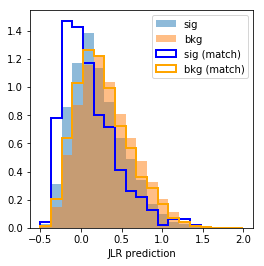

<Figure size 288x288 with 0 Axes>

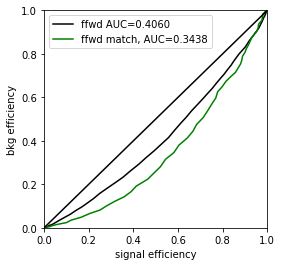

In [385]:
plot_roc(6, 2, True, 2, 2, 2)

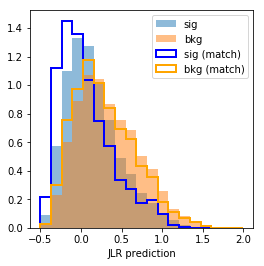

<Figure size 288x288 with 0 Axes>

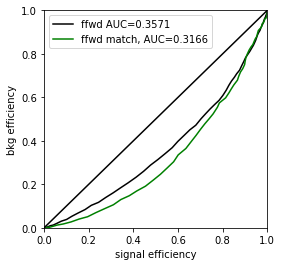

In [386]:
plot_roc(6, 3, True, 2, 2, 2)

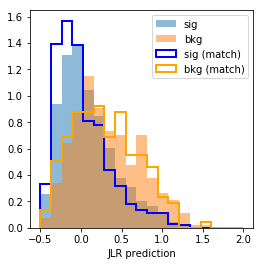

<Figure size 288x288 with 0 Axes>

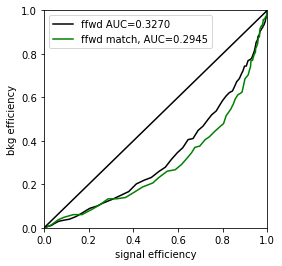

In [387]:
plot_roc(6, 4, True, 2, 2, 2)

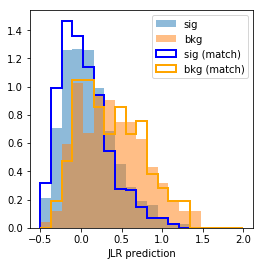

<Figure size 288x288 with 0 Axes>

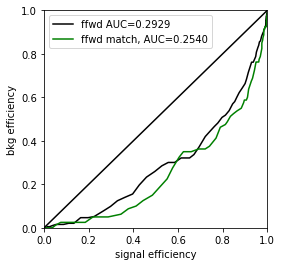

In [388]:
plot_roc(7, 4, True, 2, 2, 2)

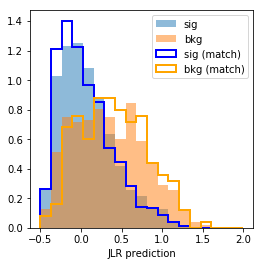

<Figure size 288x288 with 0 Axes>

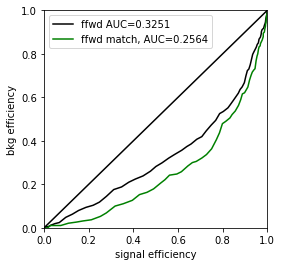

In [389]:
plot_roc(5, 4, True, 1, 2, 2)

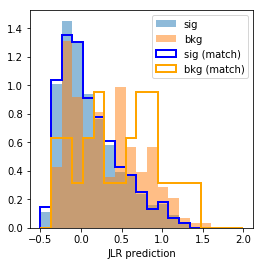

<Figure size 288x288 with 0 Axes>

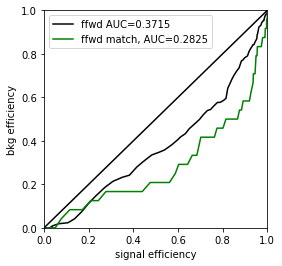

In [391]:
plot_roc(4, 4, True, 0, 2, 2)

In [375]:
metrics = pd.read_csv("/Users/joosep/Documents/jlr/results/tth_1l_ffwd/metrics.csv")

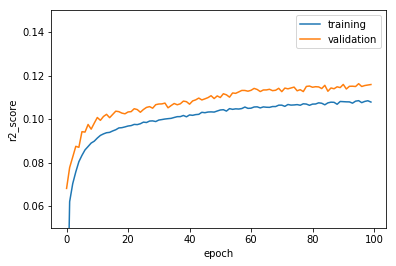

In [376]:
plt.plot(metrics["r2_score0"], label="training")
plt.plot(metrics["val_r2_score0"], label="validation")
plt.ylim(0.05, 0.15)
plt.xlabel("epoch")
plt.ylabel("r2_score")
plt.legend()